In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import f1_score
# from sklearn.metrics import jaccard_score
# import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Input data files are available in the read-only "../input/" directory

import os
data = []
for dirname, _, filenames in os.walk('../indian_liver_patient'):
    data = [os.path.join(dirname, filename) for filename in filenames if filename[-4:] == '.csv']
    break
print(data)

['../indian_liver_patient/indian_liver_patient.csv']


In [4]:
[my_data] = [pd.read_csv(data[i]) for i in range(len(data))]
my_data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


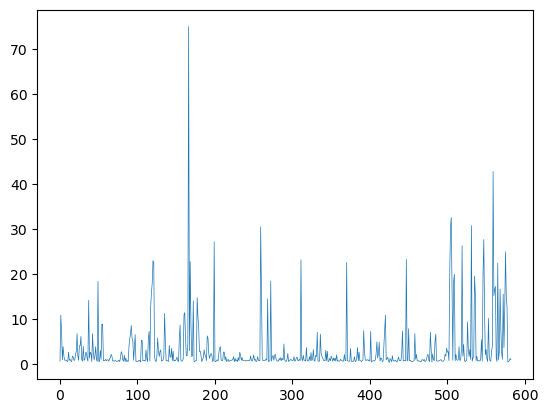

In [99]:
figure, ax1 = plt.subplots()
ax1.plot(my_data.iloc[:,2],linewidth=0.5,zorder=1, label = "Force1")
# ax1.plot(my_data.iloc[:,0],my_data.iloc[:,2],linewidth=0.5,zorder=1, label = "Force2")

LinAlgError: singular matrix

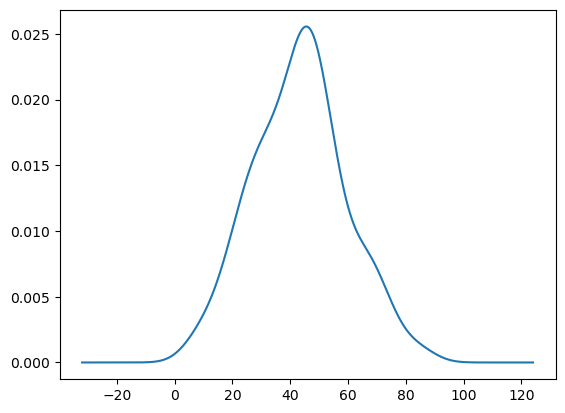

In [110]:
my_data.groupby('Gender').plot(kind='kde')

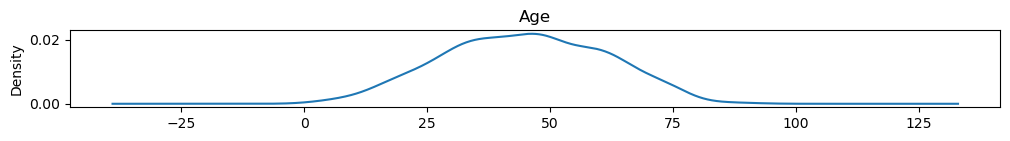

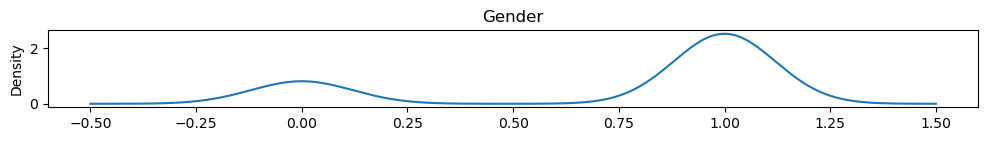

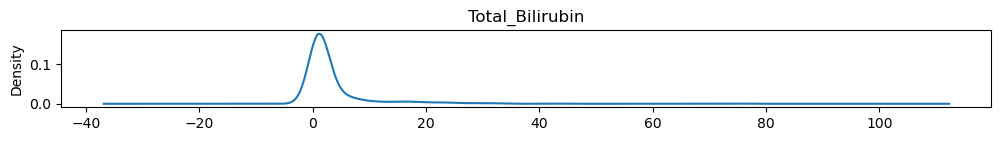

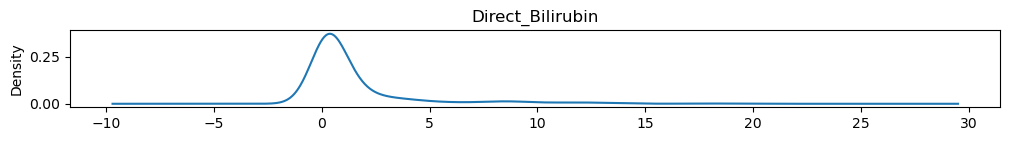

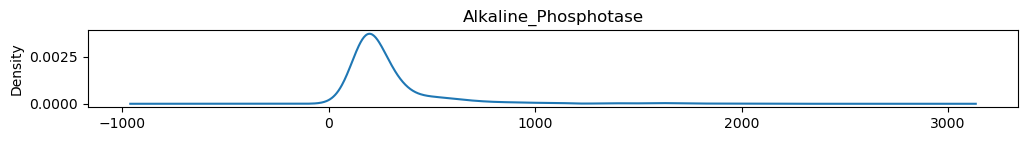

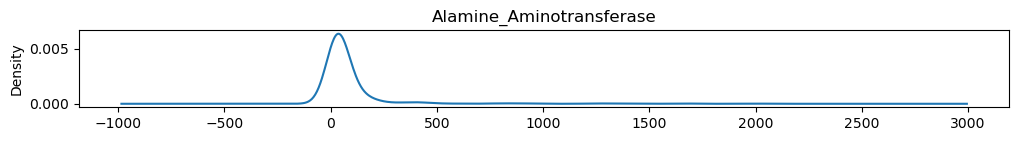

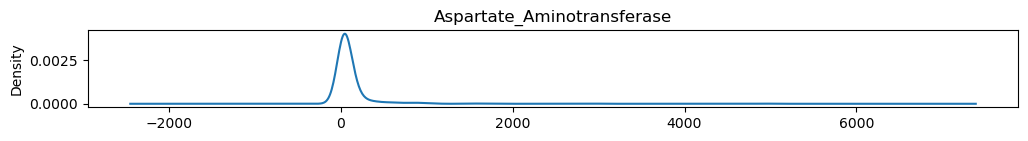

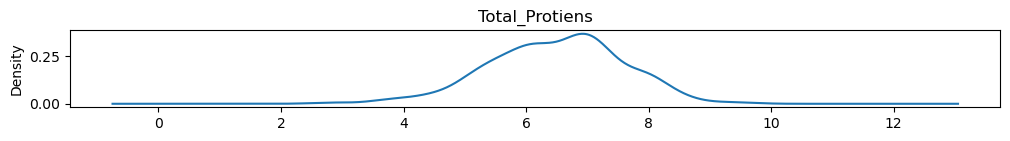

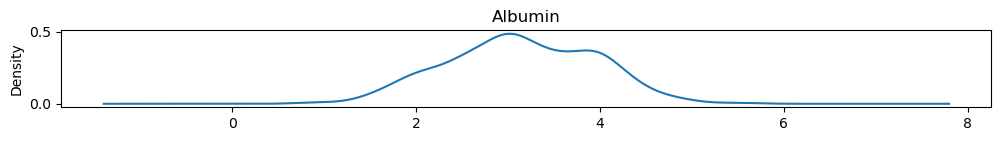

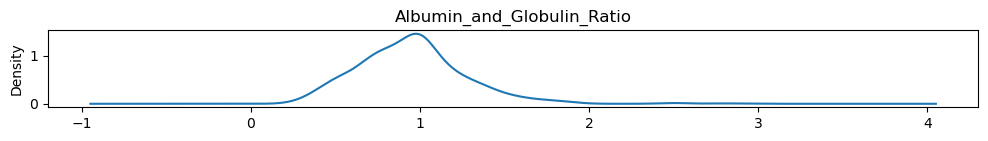

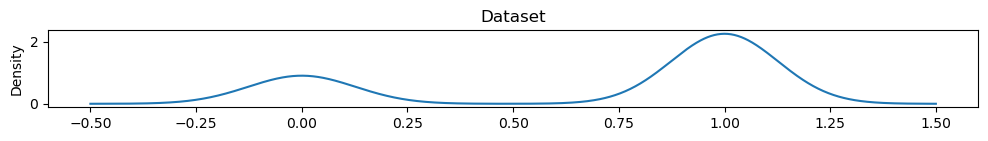

In [131]:
for column in my_data.columns:
    my_data[column].plot(title = column, figsize=(12, 1), kind='kde')
    plt.show()

In [102]:
my_data.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [5]:
my_data.shape

(583, 11)

#####  Checking for missing data

In [6]:
my_data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [7]:
my_data[my_data.isnull().any(axis=1)]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
209,45,Female,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,Male,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,Female,0.6,0.2,180,12,15,5.2,2.7,NaN,2
312,27,Male,1.3,0.6,106,25,54,8.5,4.8,NaN,2


In [11]:
my_data[["Age", "Dataset", 'Albumin_and_Globulin_Ratio']].groupby(['Age', 'Dataset']).mean()

Albumin_and_Globulin_Ratio
Age Dataset                            
4   2                          0.950000
6   2                          0.700000
7   1                          0.400000
    2                          1.100000
8   1                          0.800000
...                                 ...
75  1                          0.777143
78  1                          0.900000
84  2                          1.100000
85  2                          1.000000
90  1                          0.700000

[125 rows x 1 columns]

In [71]:
my_data.groupby(['Age', 'Dataset']).mean()['Albumin_and_Globulin_Ratio']

/var/folders/vj/01wmvprd2rv9plc81wp89lz00000gn/T/ipykernel_48402/2889210230.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  my_data.groupby(['Age', 'Dataset']).mean()['Albumin_and_Globulin_Ratio']


Age  Dataset
4    2          0.950000
6    2          0.700000
7    1          0.400000
     2          1.100000
8    1          0.800000
                  ...   
75   1          0.777143
78   1          0.900000
84   2          1.100000
85   2          1.000000
90   1          0.700000
Name: Albumin_and_Globulin_Ratio, Length: 125, dtype: float64

##### Dropping empty and useless data

In [63]:
my_data.loc[my_data['Age'].isin((45,51,35,27))][["Age", 
                                                 "Dataset", 'Albumin_and_Globulin_Ratio']].groupby(['Age', 
                                                 "Dataset"]).mean()



Albumin_and_Globulin_Ratio
Age Dataset                            
27  1                          1.000000
    2                          1.102500
35  1                          0.783333
    2                          1.200000
45  1                          0.922778
    2                          0.808333
51  1                          0.883333

In [13]:
my_data.iloc[[209,210, 241, 253, 312],[0, 1, 9]]

,Age,Gender,Albumin_and_Globulin_Ratio
209,45,Female,NaN
210,28,Male,1.4
241,51,Male,NaN
253,35,Female,NaN
312,27,Male,NaN


In [14]:
my_data['Albumin_and_Globulin_Ratio'] = my_data.groupby(['Age', 
                                    'Dataset'])['Albumin_and_Globulin_Ratio'].apply(lambda x: x.fillna(x.mean()))


/var/folders/vj/01wmvprd2rv9plc81wp89lz00000gn/T/ipykernel_66235/1827406709.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  my_data['Albumin_and_Globulin_Ratio'] = my_data.groupby(['Age',


In [15]:
#fill missing value in Age column with mean of ages in train data
print(my_data.isnull().sum())

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


In [16]:
my_data.iloc[[209,210, 241, 253, 312],[0, 1, 9]]

,Age,Gender,Albumin_and_Globulin_Ratio
209,45,Female,0.922778
210,28,Male,1.400000
241,51,Male,0.883333
253,35,Female,1.200000
312,27,Male,1.102500


In [17]:
my_data.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947613,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.318742,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [18]:
my_data.Dataset.sum()/len(my_data.Dataset)

1.2864493996569468

<AxesSubplot:>

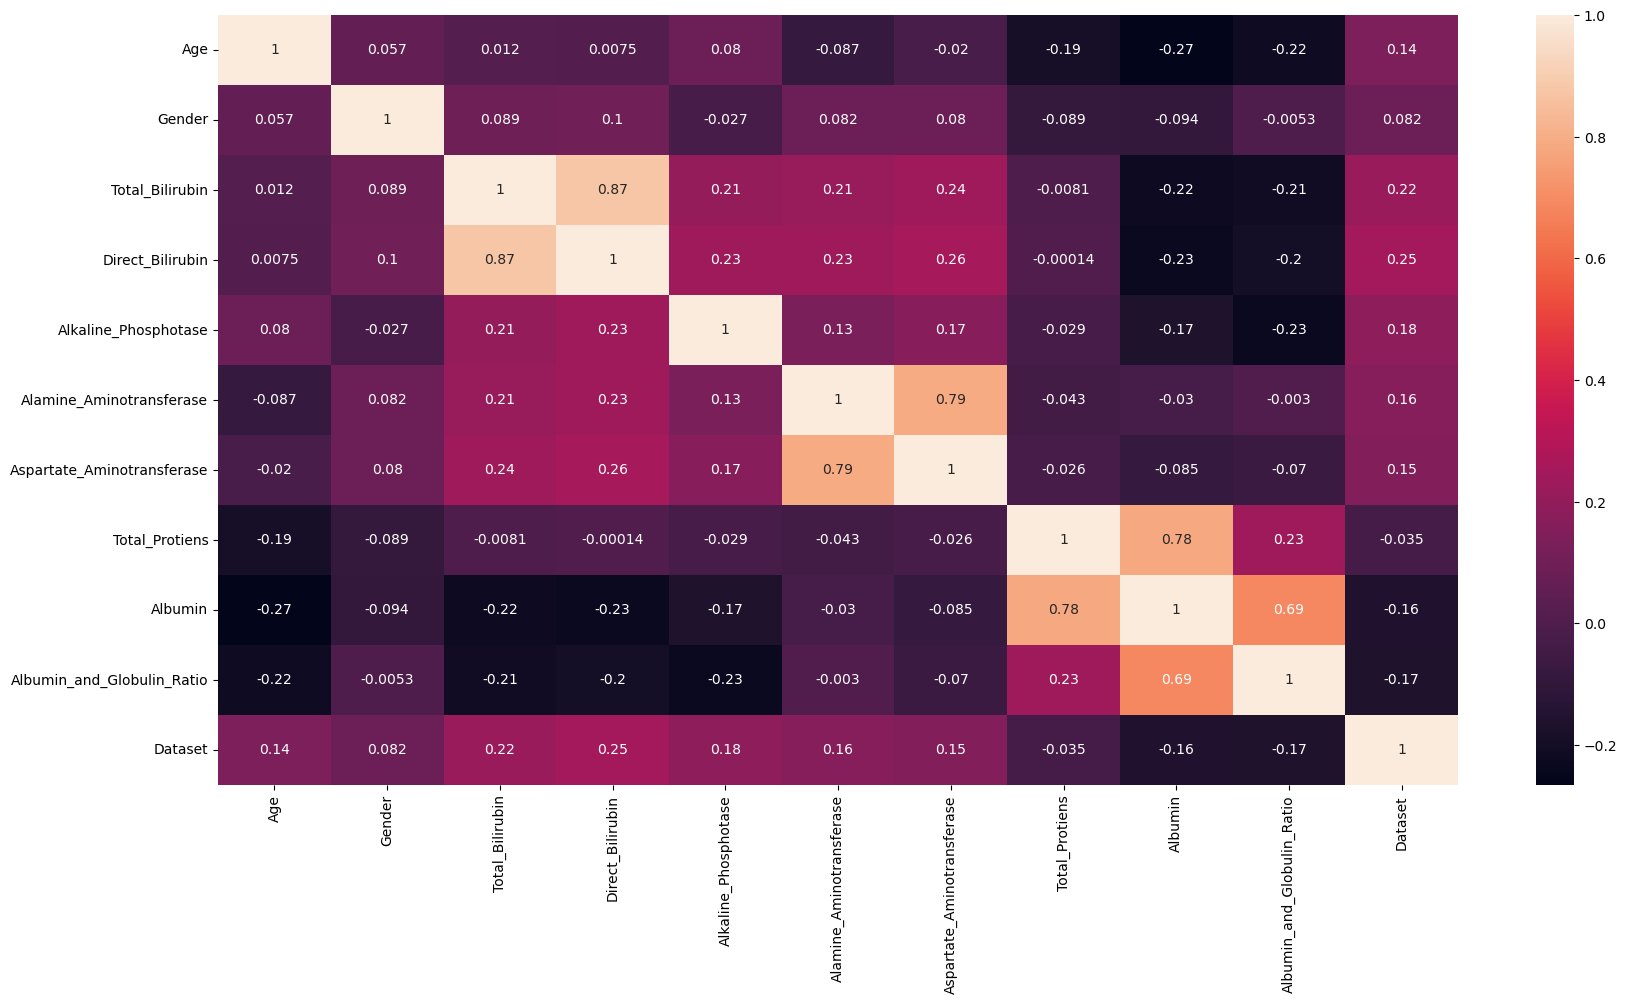

In [133]:
plt.figure(figsize=(20,10))
sns.heatmap(my_data.corr(),annot=True)

##### Changing class 2 to 0 to have classes (0,1) in Y

In [20]:
my_data.Dataset.replace(2, 0, inplace = True)

##### Changing categorical data to classes (int)

In [24]:
encoder = LabelEncoder()

encoder.fit(my_data.iloc[:,1])
my_data.loc[:,'Gender'] = encoder.transform(my_data.loc[:,'Gender'])

In [132]:
my_data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


#### Mutual information

In [172]:
X = my_data.copy()
y = X.pop("Dataset")
X.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [173]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [174]:
mi_scores = make_mi_scores(X, y)
mi_scores

Alkaline_Phosphotase          1.009414
Aspartate_Aminotransferase    1.008836
Alamine_Aminotransferase      0.740074
Age                           0.357871
Total_Bilirubin               0.080895
Direct_Bilirubin              0.062418
Gender                        0.031424
Total_Protiens                0.000000
Albumin                       0.000000
Albumin_and_Globulin_Ratio    0.000000
Name: MI Scores, dtype: float64

In [164]:
discrete_features = X.dtypes[X.dtypes != int]
discrete_features

Total_Bilirubin               float64
Direct_Bilirubin              float64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
dtype: object

In [165]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

TypeError: float() argument must be a string or a number, not 'numpy.dtype[float64]'

##### Checking for duplicated rows and dropping them

In [26]:
my_data.duplicated().sum()

13

In [27]:
# train.drop_duplicates(inplace = True)
my_data.shape

(583, 11)

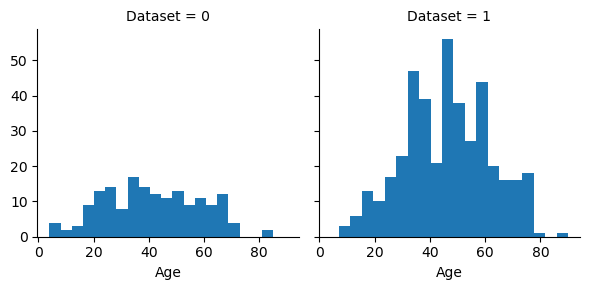

In [28]:
g = sns.FacetGrid(my_data, col='Dataset')
g.map(plt.hist, 'Age', bins=20)

In [29]:
my_data[["Gender", "Dataset"]].groupby(['Gender'], as_index=False).count().sort_values(by='Dataset', ascending=False)

,Gender,Dataset
1,1,441
0,0,142


In [30]:
my_data[["Gender", "Dataset"]].groupby(['Gender'], as_index=False).mean().sort_values(by='Dataset', ascending=False)

,Gender,Dataset
1,1,0.734694
0,0,0.647887


In [31]:
my_data[["Gender", "Dataset"]].groupby(['Gender'], as_index=False).sum().sort_values(by='Dataset', ascending=False)

,Gender,Dataset
1,1,324
0,0,92


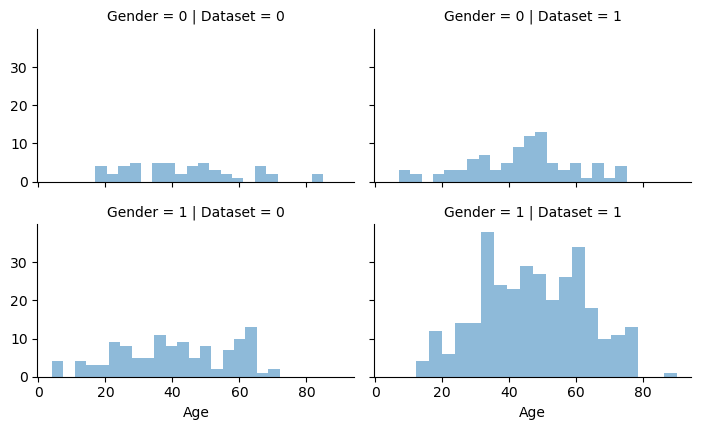

In [32]:
grid = sns.FacetGrid(my_data, col='Dataset', row='Gender', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

##### Looking for unqiue values in categorical columns

In [33]:
my_data.nunique()

Age                            72
Gender                          2
Total_Bilirubin               113
Direct_Bilirubin               80
Alkaline_Phosphotase          263
Alamine_Aminotransferase      152
Aspartate_Aminotransferase    177
Total_Protiens                 58
Albumin                        40
Albumin_and_Globulin_Ratio     72
Dataset                         2
dtype: int64

In [34]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    int64  
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  583 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.2 KB


#### Splitting into train and test; leaving test 'til the end

In [35]:
train, test = train_test_split(my_data, train_size=0.85, test_size=0.15, random_state=0)
train, valid = train_test_split(train, train_size=0.85, test_size=0.15, random_state=7)
train.Dataset.value_counts()

1    300
0    120
Name: Dataset, dtype: int64

In [36]:
train.shape

(420, 11)

In [37]:
train.Dataset.value_counts()

1    300
0    120
Name: Dataset, dtype: int64

In [38]:
test.Dataset.value_counts()

1    61
0    27
Name: Dataset, dtype: int64

In [169]:
features = ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin' ,'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
            'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']
# features = ['Age', 'Gender', 'Total_Bilirubin' ,'Alkaline_Phosphotase',
#             'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

In [65]:
X_ros, y_ros = train[features], train['Dataset']

##### Oversampling train

In [41]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(train[features], train['Dataset'])
y_ros.value_counts()

1    300
0    300
Name: Dataset, dtype: int64

In [66]:
X_ros.shape

(420, 8)

In [67]:
y_ros.shape

(420,)

In [44]:
# count_class_1, count_class_0 = train.Dataset.value_counts()
# df_class_0 = train[train['Dataset'] == 0]
# df_class_1 = train[train['Dataset'] == 1]
# df_class_0_over = df_class_1.sample(count_class_1, replace=True)
# df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

# X_ros, y_ros = df_test_over[features], df_test_over['Dataset']

In [70]:
X_train, X_valid, y_train, y_valid = X_ros, valid[features], y_ros, valid['Dataset']

In [71]:
X_train.shape

(420, 8)

In [72]:
y_train.shape

(420,)

In [48]:
# X_train = pd.concat([X_train]*5, axis=0)
# y_train = pd.concat([y_train]*5, axis=0)

In [73]:
X_train.shape

(420, 8)

In [74]:
y_train.shape

(420,)

#### RandomForestClassifier

In [75]:
#function to find resturn the result of accuracy score for RandomForestClassifier
def get_rfc(n_estimators, train_X, val_X, train_y, val_y):
    model = model = RandomForestClassifier(n_estimators=n_estimators, max_depth=5, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    return(ae)  

In [76]:
# loop to find the ideal RandomForestClassifier n_estimators
scores = {n_size: get_rfc(n_size, X_train, X_valid, y_train, y_valid) for n_size in range(80, 500, 17)}
best_n_size = max(scores, key=scores.get)

best_score = scores[best_n_size]
print('Best result at max n_neighbors : ', best_n_size)
print('accuracy score for Random Forest Classifier: ', best_score)

Best result at max n_neighbors :  216
accuracy score for Random Forest Classifier:  0.76


In [77]:
model= RandomForestClassifier(n_estimators=best_n_size, max_depth=5, random_state=1)

# Preprocessing of training data, fit model 
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
predictions = model.predict(test[features])
accuracy_score(predictions, test['Dataset'])

0.7272727272727273

#### XGBClassifier

In [78]:
#function to find resturn the result of accuracy score for XGBoost
def get_xgb(n_estimators, train_X, val_X, train_y, val_y):
    model = XGBClassifier(n_estimators = n_estimators)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    return(ae) 

In [79]:
# loop to find the ideal n_estimators size 
scores = {n_size: get_xgb(n_size, X_train, X_valid, y_train, y_valid) for n_size in range(50, 100, 10)}
best_n_size = max(scores, key=scores.get)

best_score = scores[best_n_size]
print('Best result at max n_estimators : ',best_n_size)
print('accuracy score for XGBoost: ',best_score)

Best result at max n_estimators :  70
accuracy score for XGBoost:  0.72


In [80]:
model= XGBClassifier(n_estimators=best_n_size, max_depth=5, random_state=1)

# Preprocessing of training data, fit model 
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
predictions = model.predict(test[features])
accuracy_score(predictions, test['Dataset'])

0.6590909090909091

#### LGBMClassifier

In [81]:
#function to find resturn the result of accuracy score for lgb
def get_lgb(n_estimators, train_X, val_X, train_y, val_y):
    model = lgb.LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = 0.05, max_depth = 6,
                          num_leaves = 2 ** 6,
                          metric = 'rmse',
                          application = 'regression')
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    return(ae)  

In [82]:
# loop to find the ideal n_neighbors size 
scores = {n_size: get_lgb(n_size, X_train, X_valid, y_train, y_valid) for n_size in range(1,500,50)}
best_n_size = max(scores, key=scores.get)

best_score = scores[best_n_size]
print('Best result at max n_estimators : ',best_n_size)
print('accuracy score for Ligth GBM: ',best_score)

Best result at max n_estimators :  1
accuracy score for Ligth GBM:  0.7333333333333333


In [83]:
model= lgb.LGBMClassifier(n_estimators=best_n_size, max_depth=5, random_state=1)

# Preprocessing of training data, fit model 
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
predictions = model.predict(X_valid)
accuracy_score(predictions, y_valid)

0.7333333333333333

In [84]:
predictions = model.predict(test[features])
accuracy_score(predictions, test['Dataset'])

0.6931818181818182

In [121]:
#function to find resturn the result of accuracy score for lgb
def get_lgb_f1(n_estimators, train_X, val_X, train_y, val_y):
    model = lgb.LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = 0.05, max_depth = 6,
                          num_leaves = 2 ** 6,
                          metric = 'rmse',
                          application = 'regression')
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    ae = accuracy_score(val_y, preds_val)
    rs = recall_score(val_y, preds_val) 
    ps = precision_score(val_y, preds_val) 
    f1 = precision_recall_fscore_support(val_y, preds_val)
    return(ps)

In [127]:
n_size = 370
get_lgb_f1(n_size, X_train, X_valid, y_train, y_valid)

0.775

In [75]:
LR_model = LogisticRegression(C=0.1, solver='liblinear')
LR_model.fit(X_train,y_train) 
prediction_lr = LR_model.predict(X_valid)
print('accuracy score for Logistic Regression',accuracy_score(y_valid,prediction_lr))

accuracy score for Logistic Regression 0.7008547008547008
